In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


In [5]:
image_data_path = '/content/drive/MyDrive/PreciousMD/STAN_patches_segs/patches'
labels_csv_path = '/content/drive/MyDrive/PreciousMD/STAN_patches_segs/labels/STAN_labels.csv'


In [6]:
labels_df = pd.read_csv(labels_csv_path)
print(labels_df.head())  # Display the first few rows of the labels dataframe


        UID  MUT_STATUS
0  SUB_0367           1
1  SUB_0368           0
2  SUB_0369           0
3  SUB_0370           0
4  SUB_0371           0


In [7]:
# List of patient IDs
patient_ids = os.listdir(image_data_path)
print(f"Total patients: {len(patient_ids)}")

Total patients: 116


## Ensure all patients in image folders have corresponding labels in the CSV file

In [8]:
# Get patient IDs from image folders
patient_ids_from_folders = set(os.listdir(image_data_path))

# Get patient IDs from the CSV file
patient_ids_from_csv = set(labels_df['UID'])

# Find patients in folders but not in CSV
missing_in_csv = patient_ids_from_folders - patient_ids_from_csv
if missing_in_csv:
    print(f"Patients present in folders but missing in CSV: {missing_in_csv}")
else:
    print("All patients in folders have corresponding labels in the CSV file.")

# Find patients in CSV but not in folders
missing_in_folders = patient_ids_from_csv - patient_ids_from_folders
if missing_in_folders:
    print(f"Patients present in CSV but missing in folders: {missing_in_folders}")
else:
    print("All patients in the CSV file have corresponding folders.")


All patients in folders have corresponding labels in the CSV file.
Patients present in CSV but missing in folders: {'SUB_0380'}


In [9]:
# Check for duplicates in the CSV file
duplicate_patients_in_csv = labels_df[labels_df['UID'].duplicated()]['UID']
if not duplicate_patients_in_csv.empty:
    print(f"Duplicate patient IDs in CSV: {duplicate_patients_in_csv.to_list()}")
else:
    print("No duplicate patient IDs in the CSV file.")

# Check for duplicate folders (this is unlikely since operating systems usually don't allow duplicate folder names, but it's good to double-check)
if len(patient_ids_from_folders) != len(os.listdir(image_data_path)):
    print("There might be duplicate folders. Please check manually.")
else:
    print("No duplicate folders detected.")


No duplicate patient IDs in the CSV file.
No duplicate folders detected.


In [10]:
# Check for duplicates in the CSV file
duplicate_patients_in_csv = labels_df[labels_df['UID'].duplicated()]['UID']
if not duplicate_patients_in_csv.empty:
    print(f"Duplicate patient IDs in CSV: {duplicate_patients_in_csv.to_list()}")
else:
    print("No duplicate patient IDs in the CSV file.")

# Check for duplicate folders (this is unlikely since operating systems usually don't allow duplicate folder names, but it's good to double-check)
if len(patient_ids_from_folders) != len(os.listdir(image_data_path)):
    print("There might be duplicate folders. Please check manually.")
else:
    print("No duplicate folders detected.")


No duplicate patient IDs in the CSV file.
No duplicate folders detected.


Given the results:

All patients in folders have corresponding labels in the CSV file:
This ensures that there won't be any "unlabeled" data issues when you proceed with training or validation. It means that every image you use will have an associated label.
Patients present in CSV but missing in folders: {'SUB_0380'}:
This indicates that while you have a label for patient SUB_0380, you do not have their image data. This discrepancy needs to be addressed before training.
Next Steps:

Address Missing Data: You need to decide how to address the missing image data for patient SUB_0380. Here are a few strategies:
a. Data Retrieval: If the missing data can be retrieved, locate the source of your dataset and check if the images for SUB_0380 were mistakenly excluded or misplaced.
b. Remove from CSV: If you can't retrieve the missing image data, it's best to remove the entry for SUB_0380 from the CSV file. This ensures consistency between your labels and data.

In [11]:
# Remove the SUB_0380 entry from the DataFrame
labels_df = labels_df[labels_df['UID'] != 'SUB_0380']


# Update the list of patient IDs to ensure it doesn't contain SUB_0380 and only includes IDs from the CSV that exist in the directory.
patient_ids = [pid for pid in os.listdir(image_data_path) if pid in labels_df['UID'].values]


In [12]:
"""
import cv2

def plot_images_for_patient(patient_id):
    patient_folder = os.path.join(image_data_path, patient_id)
    images = os.listdir(patient_folder)

    fig, axs = plt.subplots(1, 5, figsize=(20, 20))
    for i, image_file in enumerate(images[:5]):
        img_path = os.path.join(patient_folder, image_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img)
        axs[i].set_title(image_file)
        axs[i].axis('off')

# Plot images for a sample patient
for i in range(10):
  plot_images_for_patient(patient_ids[i])

"""

"\nimport cv2\n\ndef plot_images_for_patient(patient_id):\n    patient_folder = os.path.join(image_data_path, patient_id)\n    images = os.listdir(patient_folder)\n\n    fig, axs = plt.subplots(1, 5, figsize=(20, 20))\n    for i, image_file in enumerate(images[:5]):\n        img_path = os.path.join(patient_folder, image_file)\n        img = cv2.imread(img_path)\n        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n        axs[i].imshow(img)\n        axs[i].set_title(image_file)\n        axs[i].axis('off')\n\n# Plot images for a sample patient\nfor i in range(10):\n  plot_images_for_patient(patient_ids[i])\n\n"

0    93
1    23
Name: MUT_STATUS, dtype: int64
0    80.172414
1    19.827586
Name: MUT_STATUS, dtype: float64


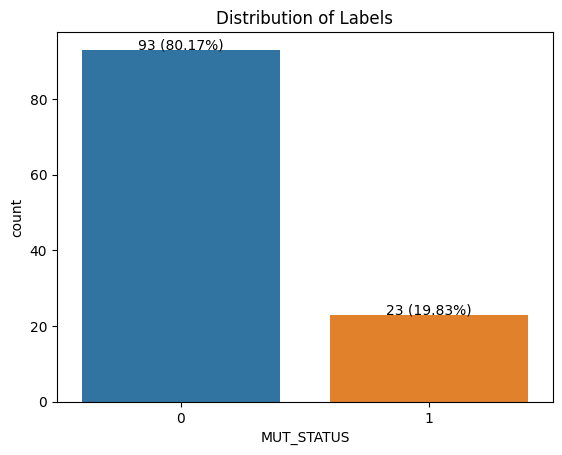

In [13]:
# Check the distribution of labels
label_distribution = labels_df['MUT_STATUS'].value_counts()
print(label_distribution)

# Get the distribution in percentages
label_distribution_percent = labels_df['MUT_STATUS'].value_counts(normalize=True) * 100
print(label_distribution_percent)

# Visualizing the distribution of labels along with counts
sns.countplot(x='MUT_STATUS', data=labels_df).set_title('Distribution of Labels')
for i, count in enumerate(label_distribution):
    plt.text(i, count, f'{count} ({label_distribution_percent.iloc[i]:.2f}%)', ha='center', va='baseline')
plt.show()

In [14]:
import numpy as np
import cv2
# For simplicity, let's check the statistics for a single patient's images
patient_folder = os.path.join(image_data_path, patient_ids[0])
images = os.listdir(patient_folder)

pixel_values = []
for image_file in images:
    img_path = os.path.join(patient_folder, image_file)
    img = cv2.imread(img_path)
    pixel_values.extend(img.ravel())

pixel_values = np.array(pixel_values)
print(f"Mean: {np.mean(pixel_values)}, Std: {np.std(pixel_values)}, Min: {np.min(pixel_values)}, Max: {np.max(pixel_values)}")


Mean: 120.35284375, Std: 14.992430424653834, Min: 77, Max: 198


In [15]:
# Quick script to get the distribution of the number of images per patient
image_count_per_patient = {patient_id: len(os.listdir(os.path.join(image_data_path, patient_id))) for patient_id in labels_df['UID']}
image_count_distribution = pd.Series(image_count_per_patient).value_counts()
print(image_count_distribution)


5    116
dtype: int64


In [16]:
"""# Quick script to get unique image sizes across all patients
unique_image_sizes = set()
for patient_id in labels_df['UID']:
    patient_folder = os.path.join(image_data_path, patient_id)
    for img_name in os.listdir(patient_folder):
        img_path = os.path.join(patient_folder, img_name)
        img = Image.open(img_path)
        unique_image_sizes.add(img.size)
print(unique_image_sizes)
"""

"# Quick script to get unique image sizes across all patients\nunique_image_sizes = set()\nfor patient_id in labels_df['UID']:\n    patient_folder = os.path.join(image_data_path, patient_id)\n    for img_name in os.listdir(patient_folder):\n        img_path = os.path.join(patient_folder, img_name)\n        img = Image.open(img_path)\n        unique_image_sizes.add(img.size)\nprint(unique_image_sizes)\n"

## Histogram Analysis:
Given that you're dealing with tumors, the intensity distribution might reveal whether the image has good contrast between the tumor and the surrounding tissue. It might also indicate if the image is too dark or too bright.

In [17]:
import cv2

def plot_histogram_for_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Grayscale for a simple histogram

    plt.hist(img.ravel(), bins=256, range=(0,256), fc='k', ec='k')
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()


In [18]:
"""import random

sample_patient_ids = random.sample(patient_ids, 5)  # Sample 5 random patients

for patient_id in sample_patient_ids:
    patient_folder = os.path.join(image_data_path, patient_id)
    image_files = os.listdir(patient_folder)
    sample_image_file = random.choice(image_files)  # Sample one image from the patient
    image_path = os.path.join(patient_folder, sample_image_file)

    print(f"Patient ID: {patient_id}, Image: {sample_image_file}")
    plot_histogram_for_image(image_path)
"""

'import random\n\nsample_patient_ids = random.sample(patient_ids, 5)  # Sample 5 random patients\n\nfor patient_id in sample_patient_ids:\n    patient_folder = os.path.join(image_data_path, patient_id)\n    image_files = os.listdir(patient_folder)\n    sample_image_file = random.choice(image_files)  # Sample one image from the patient\n    image_path = os.path.join(patient_folder, sample_image_file)\n\n    print(f"Patient ID: {patient_id}, Image: {sample_image_file}")\n    plot_histogram_for_image(image_path)\n'

# Using one image only

# Creating PyTorch Dataset

In [19]:
import os
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image

class TumorDataset(torch.utils.data.Dataset):
    def __init__(self, image_data_path, labels_df):
        self.image_data_path = image_data_path

        # Load the CSV file into a DataFrame
        self.labels_df = labels_df

        # Maximum size based on the unique image sizes you provided
        self.max_size = (120, 120)

        # Transformation pipeline
        self.transform = transforms.Compose([
          transforms.Resize(self.max_size),
          transforms.Pad((0, 0, self.max_size[0] - self.labels_df.shape[1], self.max_size[1] - self.labels_df.shape[0]), fill=0),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize to [0, 1]
          transforms.RandomHorizontalFlip(),  # Data augmentation
          transforms.RandomRotation(degrees=10)  # Data augmentation
      ])


    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, index):
        # Fetch the patient ID and label for the given index
        patient_id = self.labels_df.iloc[index]["UID"]
        label = self.labels_df.iloc[index]["MUT_STATUS"]

        # Define the path to the patient's images
        patient_image_path = os.path.join(self.image_data_path, patient_id)

        # Load all images for the given patient
        images = []
        for img_name in sorted(os.listdir(patient_image_path)):  # Sorting ensures consistent order
            img_path = os.path.join(patient_image_path, img_name)
            img = Image.open(img_path).convert('L')  # Convert to grayscale (L mode in PIL)
            img = self.transform(img)
            images.append(img)

        # Stack images into a tensor
        images = torch.stack(images, dim=0)

        return images, label



image_data_path = '/content/drive/MyDrive/PreciousMD/STAN_patches_segs/patches'
labels_csv_path = '/content/drive/MyDrive/PreciousMD/STAN_patches_segs/labels/STAN_labels.csv'



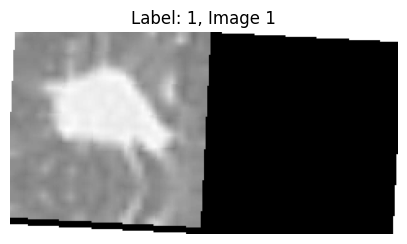

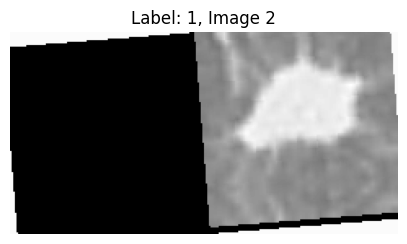

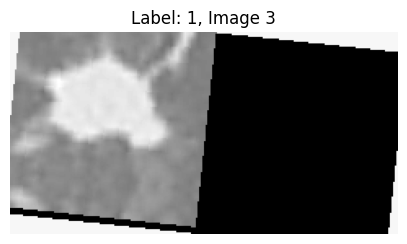

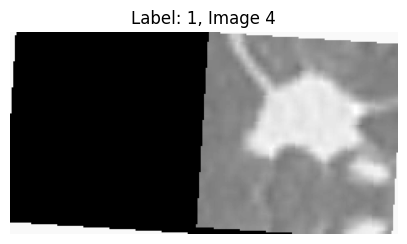

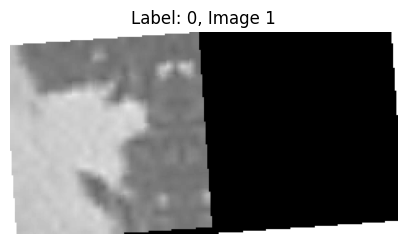

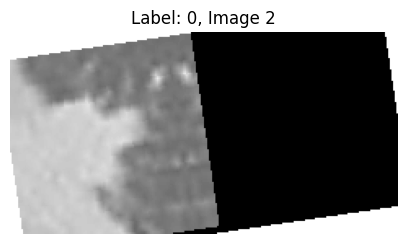

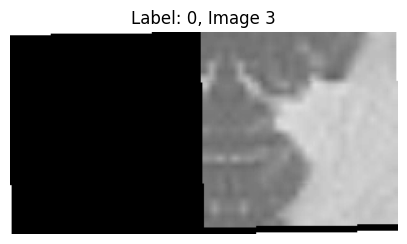

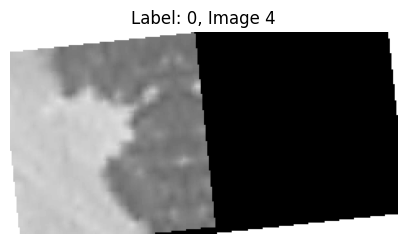

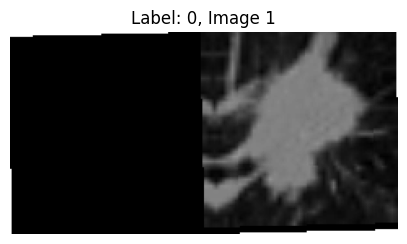

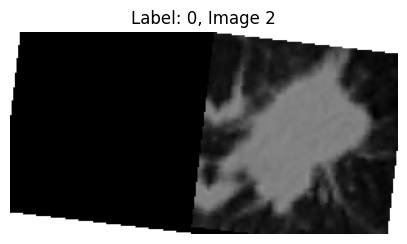

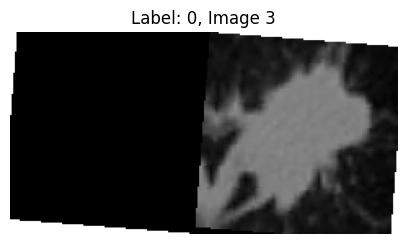

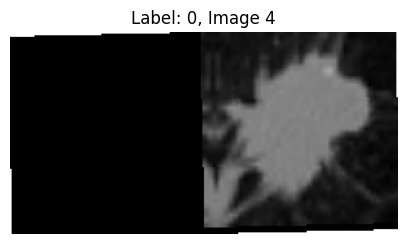

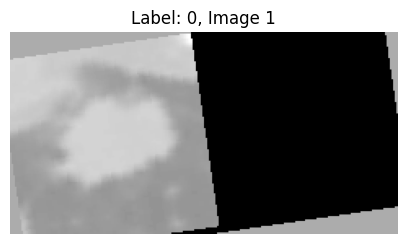

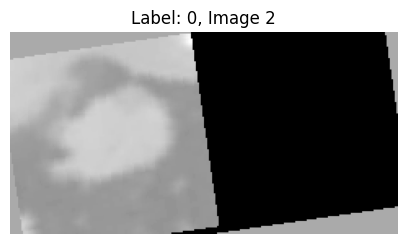

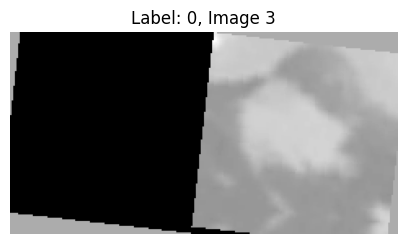

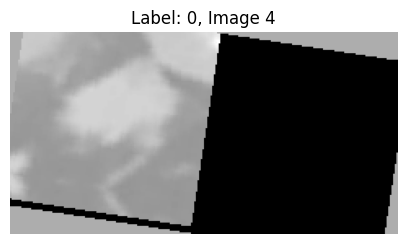

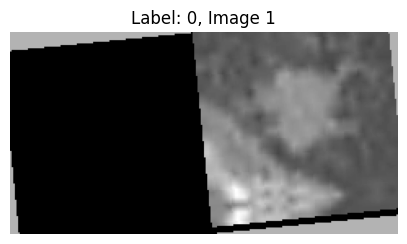

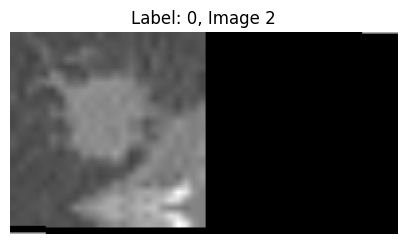

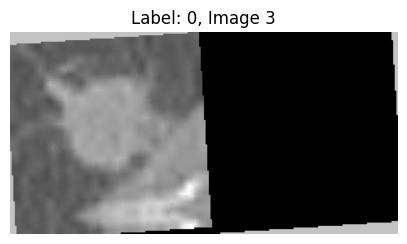

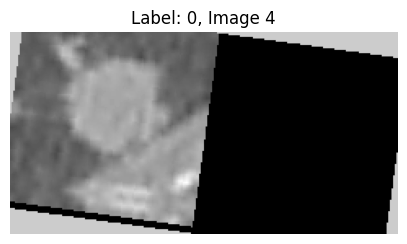

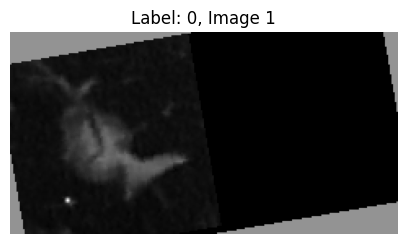

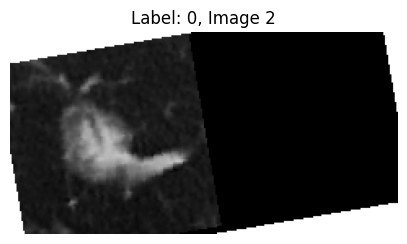

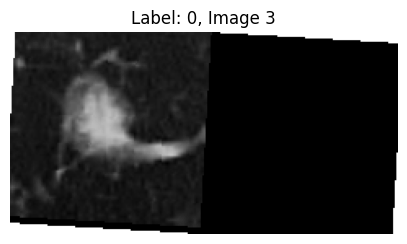

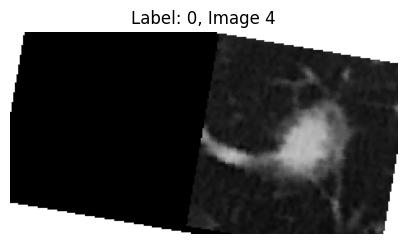

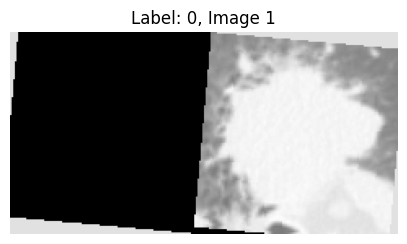

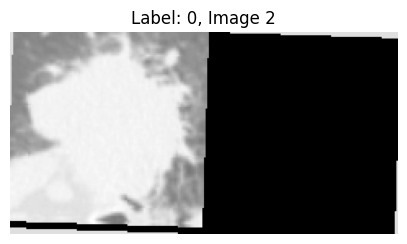

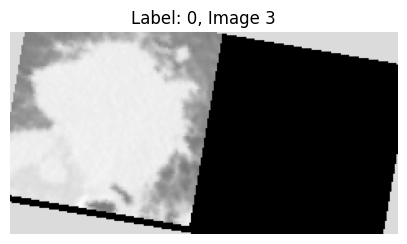

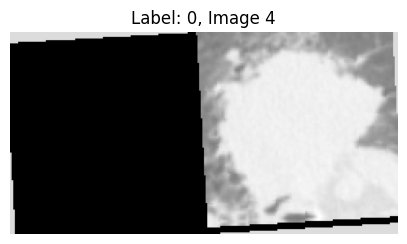

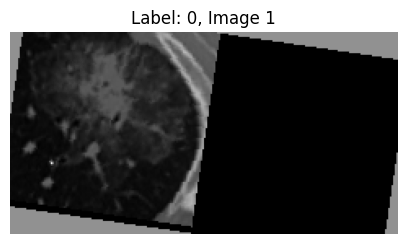

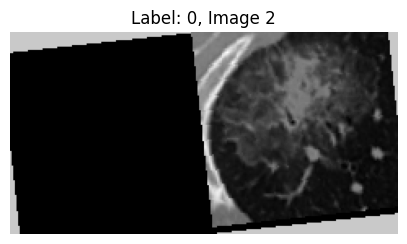

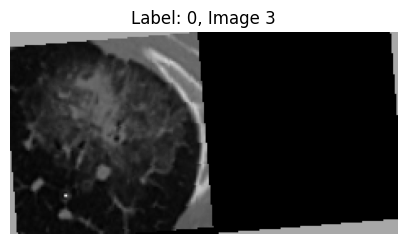

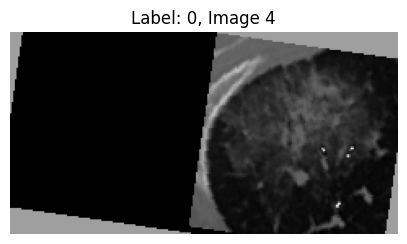

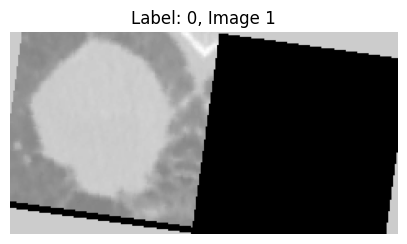

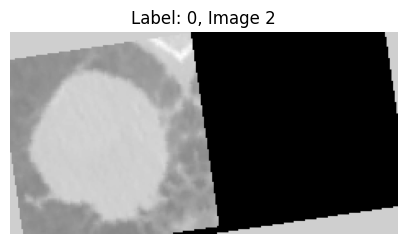

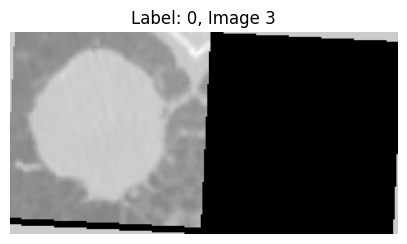

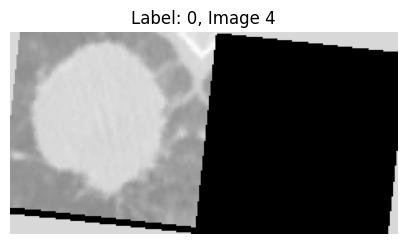

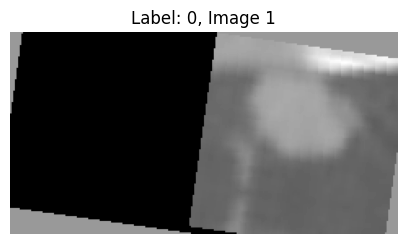

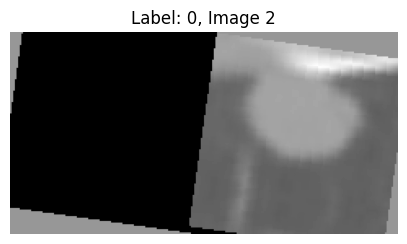

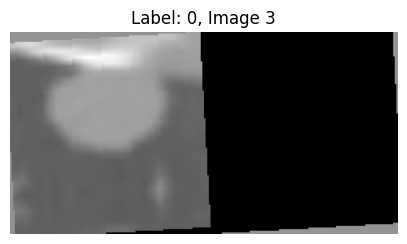

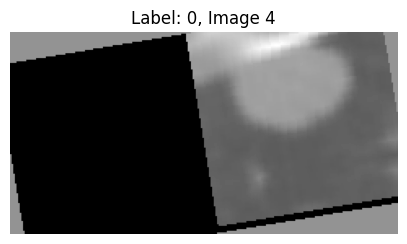

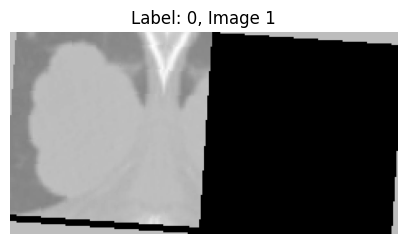

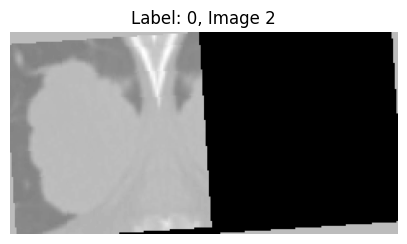

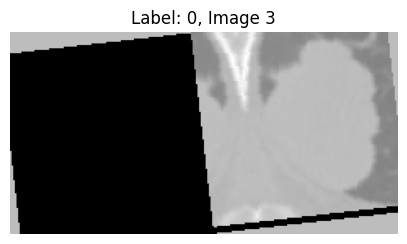

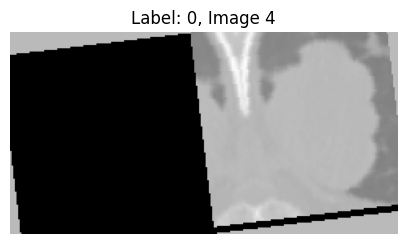

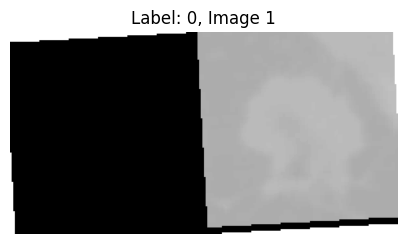

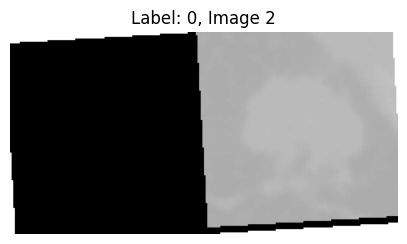

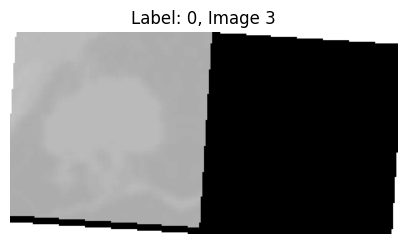

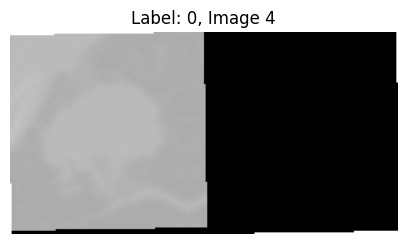

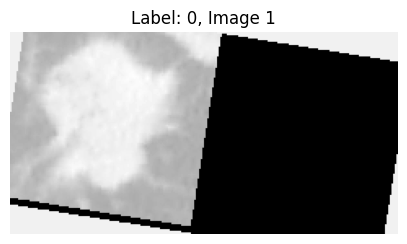

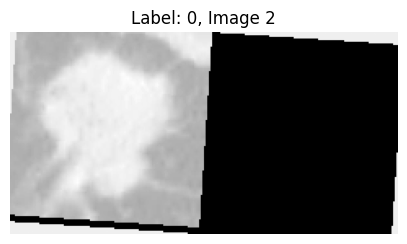

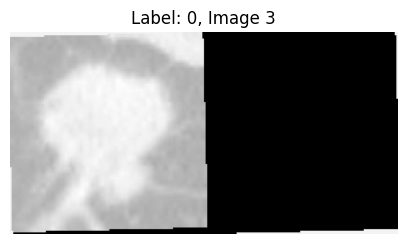

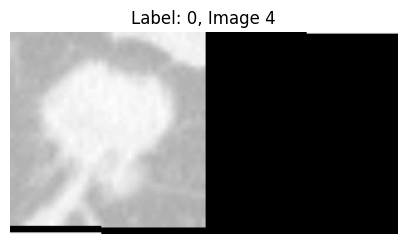

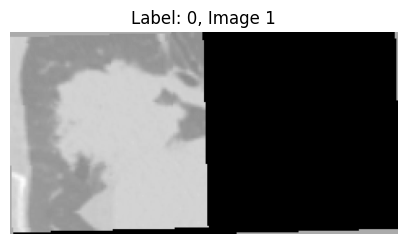

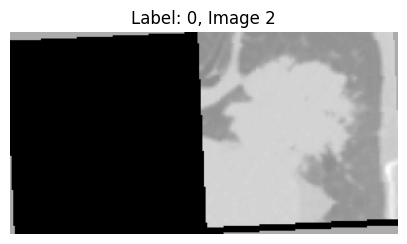

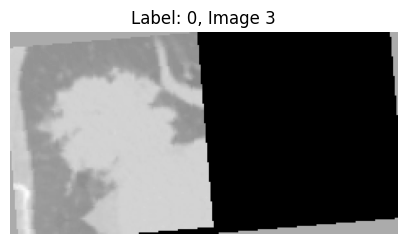

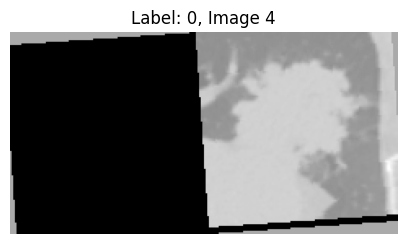

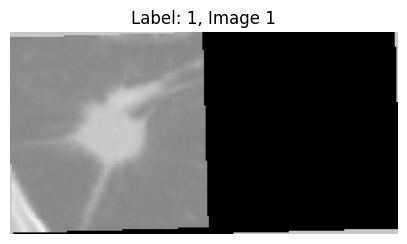

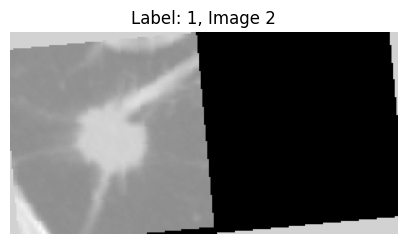

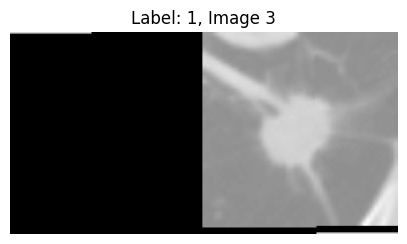

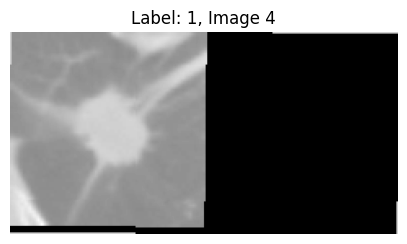

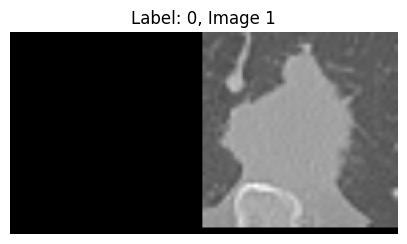

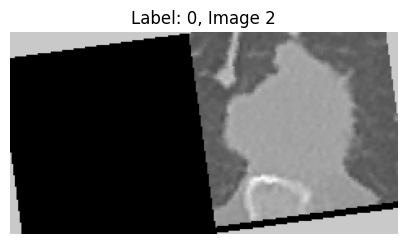

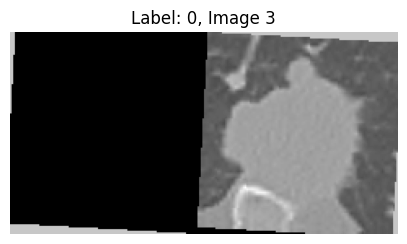

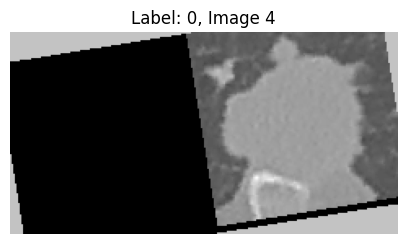

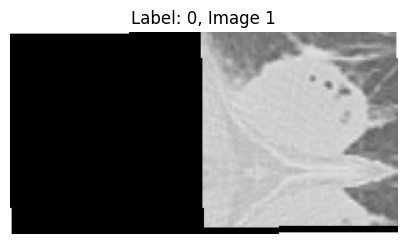

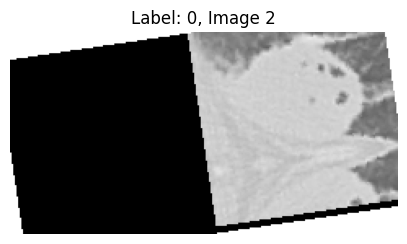

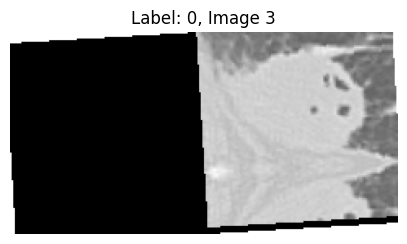

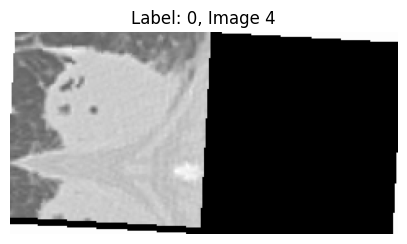

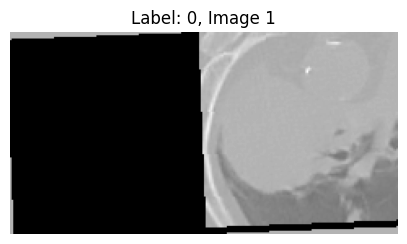

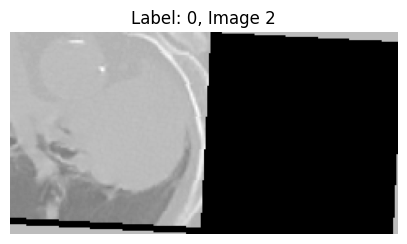

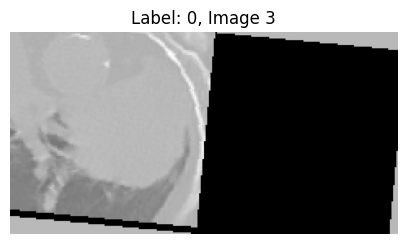

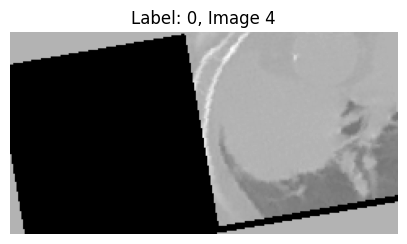

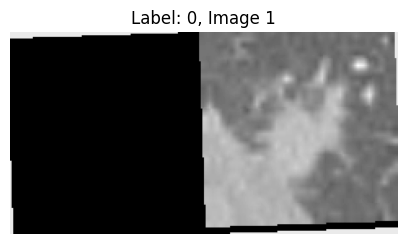

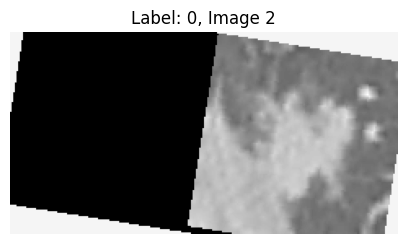

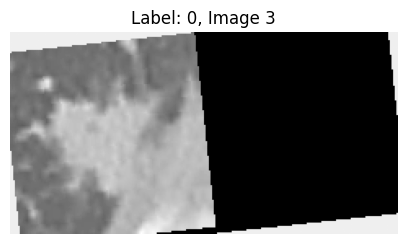

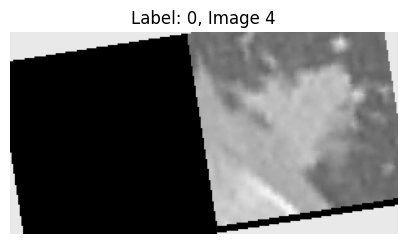

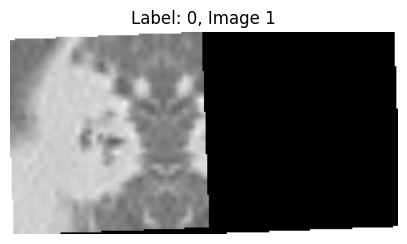

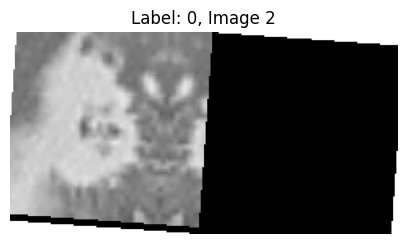

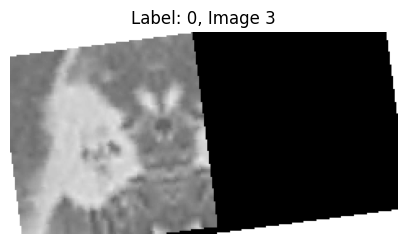

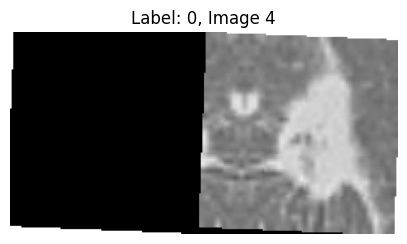

In [21]:
# Instantiating the dataset
dataset = TumorDataset(image_data_path, labels_df)
import matplotlib.pyplot as plt

num_samples_to_display = 20
num_images_per_patient = 4 # Adjust this if it's different in your dataset

for i in range(num_samples_to_display):
    combined_image, label = dataset[i]

    # Selecting the first `num_images_per_patient` images
    individual_images = combined_image[:num_images_per_patient]

    # Display each image
    for j, image in enumerate(individual_images):
        plt.figure(figsize=(5,5))
        plt.imshow(image.squeeze().numpy(), cmap='gray')  # Use the grayscale colormap
        plt.title(f"Label: {label}, Image {j+1}")
        plt.axis('off')
        plt.show()



# Data Splitting

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the features (X) and labels (y)
X = patient_ids
y = labels_df['MUT_STATUS']

# Define the number of splits and the test size for the initial split
n_splits = 1  # You can adjust this based on your needs
test_size_initial = 0.2  # 20% for test, 80% for train and validation

# Initialize StratifiedShuffleSplit for the initial split
sss_initial = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size_initial, random_state=42)

# Perform the initial split
for train_index_initial, test_index in sss_initial.split(X, y):
    train_patient_ids_initial = [X[i] for i in train_index_initial]
    test_patient_ids = [X[i] for i in test_index]
    X_train_initial = labels_df[labels_df['UID'].isin(train_patient_ids_initial)]
    X_test = labels_df[labels_df['UID'].isin(test_patient_ids)]
    y_train_initial = X_train_initial['MUT_STATUS']
    y_test = X_test['MUT_STATUS']

# Define the number of splits and the validation size for the second split
n_splits = 1  # You can adjust this based on your needs
validation_size = 0.1  # 10% for validation, 90% for final training

# Initialize StratifiedShuffleSplit for the second split
sss_final = StratifiedShuffleSplit(n_splits=n_splits, test_size=validation_size, random_state=42)

# Perform the second split
for train_index_final, validation_index in sss_final.split(X_train_initial, y_train_initial):
    train_patient_ids_final = [train_patient_ids_initial[i] for i in train_index_final]
    validation_patient_ids = [train_patient_ids_initial[i] for i in validation_index]
    X_train = labels_df[labels_df['UID'].isin(train_patient_ids_final)]
    X_val = labels_df[labels_df['UID'].isin(validation_patient_ids)]
    y_train = X_train['MUT_STATUS']
    y_val = X_val['MUT_STATUS']

# Now X_train, y_train, X_val, y_val, X_test, y_test contain the data for training, validation, and testing


In [25]:
# Check class distribution
original_class_distribution = labels_df['MUT_STATUS'].value_counts(normalize=True)
train_class_distribution = y_train.value_counts(normalize=True)
val_class_distribution = y_val.value_counts(normalize=True)
test_class_distribution = y_test.value_counts(normalize=True)

print("Original Class Distribution:")
print(original_class_distribution)

print("Training Class Distribution:")
print(train_class_distribution)

print("Validation Class Distribution:")
print(val_class_distribution)

print("Test Class Distribution:")
print(test_class_distribution)

# Check for patient overlap
train_patients = set(train_patient_ids_final)
val_patients = set(validation_patient_ids)
test_patients = set(test_patient_ids)

overlap_train_val = train_patients.intersection(val_patients)
overlap_train_test = train_patients.intersection(test_patients)
overlap_val_test = val_patients.intersection(test_patients)

if overlap_train_val or overlap_train_test or overlap_val_test:
    print("Data leakage detected. Patient overlap between sets.")
else:
    print("No data leakage. Sets are mutually exclusive.")

# Check data shapes
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)


Original Class Distribution:
0    0.801724
1    0.198276
Name: MUT_STATUS, dtype: float64
Training Class Distribution:
0    0.804878
1    0.195122
Name: MUT_STATUS, dtype: float64
Validation Class Distribution:
0    0.8
1    0.2
Name: MUT_STATUS, dtype: float64
Test Class Distribution:
0    0.791667
1    0.208333
Name: MUT_STATUS, dtype: float64
No data leakage. Sets are mutually exclusive.
Training set shape: (82, 2)
Validation set shape: (10, 2)
Test set shape: (24, 2)
